<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Detecting_dementia_from_speech_and_transcripts_using_transformers_May24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Step 1: Environment Setup and Dependencies
# Run this cell first to install all required packages

!pip install transformers torch torchvision torchaudio
!pip install librosa pandas numpy scikit-learn
!pip install datasets accelerate

# Import all necessary libraries
import os
import pandas as pd
import numpy as np
import tarfile
import csv
from pathlib import Path
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertModel,
    ViTFeatureExtractor, ViTModel,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive (uncomment if using Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


In [6]:
# Step 2: Data Extraction and Organization

def extract_tgz_archive(archive_path, extract_to):
    """
    Extract .tgz archive to specified directory
    """
    try:
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {archive_path} to {extract_to}")
    except Exception as e:
        print(f"Error extracting {archive_path}: {str(e)}")

def collect_adresso_data(base_path, task_type, split_type):
    """
    Collect ADReSSo data and create DataFrame with file paths and labels

    Args:
        base_path: Path to extracted ADReSSo data
        task_type: 'diagnosis' or 'progression'
        split_type: 'train' or 'test'

    Returns:
        DataFrame with columns: audio_path, transcript_path, label, participant_id
    """
    data_list = []

    # Define paths - try multiple possible directory structures
    possible_paths = [
        os.path.join(base_path, f"ADReSSo21-{task_type}-{split_type}"),
        os.path.join(base_path, f"ADReSSo21/{task_type}/{split_type}"),
        os.path.join(base_path, f"{task_type}-{split_type}"),
        os.path.join(base_path, task_type, split_type)
    ]

    data_root = None
    for path in possible_paths:
        if os.path.exists(path):
            data_root = path
            break

    if data_root is None:
        print(f"Could not find data directory for {task_type}-{split_type}")
        print(f"Searched in: {possible_paths}")
        print(f"Available directories in {base_path}:")
        if os.path.exists(base_path):
            for item in os.listdir(base_path):
                item_path = os.path.join(base_path, item)
                if os.path.isdir(item_path):
                    print(f"  - {item}")
        return pd.DataFrame()

    print(f"Found data root: {data_root}")

    # Look for audio and transcript directories
    audio_base = os.path.join(data_root, "audio")
    transcript_base = os.path.join(data_root, "segmentation")

    # If not found, try alternative names
    if not os.path.exists(audio_base):
        for alt_name in ["Audio", "wav", "sound"]:
            alt_path = os.path.join(data_root, alt_name)
            if os.path.exists(alt_path):
                audio_base = alt_path
                break

    if not os.path.exists(transcript_base):
        for alt_name in ["transcripts", "text", "csv", "Transcripts"]:
            alt_path = os.path.join(data_root, alt_name)
            if os.path.exists(alt_path):
                transcript_base = alt_path
                break

    print(f"Audio directory: {audio_base} (exists: {os.path.exists(audio_base)})")
    print(f"Transcript directory: {transcript_base} (exists: {os.path.exists(transcript_base)})")

    if not os.path.exists(audio_base) or not os.path.exists(transcript_base):
        print("Could not find both audio and transcript directories")
        return pd.DataFrame()

    # Define label mapping based on task type
    if task_type == 'diagnosis':
        label_dirs = ['ad', 'cn']  # Alzheimer's Disease, Cognitively Normal
    else:  # progression
        label_dirs = ['decline', 'no_decline']

    # Check if label subdirectories exist, if not, process all files in the base directory
    has_label_subdirs = any(os.path.exists(os.path.join(audio_base, label_dir)) for label_dir in label_dirs)

    if has_label_subdirs:
        print("Found label subdirectories")
        for label_dir in label_dirs:
            audio_dir = os.path.join(audio_base, label_dir)
            transcript_dir = os.path.join(transcript_base, label_dir)

            if os.path.exists(audio_dir) and os.path.exists(transcript_dir):
                # Get all audio files
                audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

                for audio_file in audio_files:
                    # Extract participant ID (assuming format like 'S001.wav')
                    participant_id = audio_file.split('.')[0]

                    # Find corresponding transcript file
                    transcript_file = f"{participant_id}.csv"

                    audio_path = os.path.join(audio_dir, audio_file)
                    transcript_path = os.path.join(transcript_dir, transcript_file)

                    # Check if both files exist
                    if os.path.exists(audio_path) and os.path.exists(transcript_path):
                        data_list.append({
                            'audio_path': audio_path,
                            'transcript_path': transcript_path,
                            'label': label_dir,
                            'participant_id': participant_id
                        })
    else:
        print("No label subdirectories found, processing all files")
        # Process all files in the base directories
        if os.path.exists(audio_base):
            audio_files = [f for f in os.listdir(audio_base) if f.endswith('.wav')]

            for audio_file in audio_files:
                participant_id = audio_file.split('.')[0]

                # Look for corresponding transcript
                transcript_file = f"{participant_id}.csv"
                transcript_path = os.path.join(transcript_base, transcript_file)

                if not os.path.exists(transcript_path):
                    # Try alternative extensions
                    for ext in ['.txt', '.tsv']:
                        alt_transcript = f"{participant_id}{ext}"
                        alt_path = os.path.join(transcript_base, alt_transcript)
                        if os.path.exists(alt_path):
                            transcript_path = alt_path
                            break

                audio_path = os.path.join(audio_base, audio_file)

                if os.path.exists(transcript_path):
                    # Default label assignment - you may need to modify this based on your data
                    label = 'unknown'  # You'll need to determine labels from metadata or filenames

                    data_list.append({
                        'audio_path': audio_path,
                        'transcript_path': transcript_path,
                        'label': label,
                        'participant_id': participant_id
                    })

    df = pd.DataFrame(data_list)
    print(f"Collected {len(df)} samples for {task_type}-{split_type}")

    if len(df) > 0:
        print(f"Label distribution:\n{df['label'].value_counts()}")
    else:
        print("No data collected. Please check your directory structure.")

    return df

# Example usage - update paths according to your Drive structure
BASE_PATH = "/content/drive/MyDrive/Voice"  # Update this path
EXTRACT_TO = "/content/ADReSSo_extracted"  # Local extraction directory

# Extract archives if needed
archive_files = [
    "ADReSSo21-diagnosis-train.tgz",
    "ADReSSo21-diagnosis-test.tgz"  # Add this if you have the test archive too
]

print("Extracting archives...")
for archive_file in archive_files:
    archive_path = os.path.join(BASE_PATH, archive_file)
    if os.path.exists(archive_path):
        print(f"Extracting {archive_file}...")
        extract_tgz_archive(archive_path, EXTRACT_TO)
    else:
        print(f"Archive not found: {archive_path}")

# Now collect data from the extracted directory
train_df = collect_adresso_data(EXTRACT_TO, 'diagnosis', 'train')

# Only proceed if we have data
if len(train_df) > 0:
    # Try to collect test data if available
    test_df = collect_adresso_data(EXTRACT_TO, 'diagnosis', 'test')

    # If no test data found, we'll use train data for testing (not ideal but for demo)
    if len(test_df) == 0:
        print("No separate test data found. Will use part of training data for testing.")
        test_df = train_df.sample(n=min(10, len(train_df)//4), random_state=42)
        train_df = train_df.drop(test_df.index).reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)

    # Split training data into train and validation only if we have labels
    if 'label' in train_df.columns and train_df['label'].nunique() > 1:
        train_split, val_split = train_test_split(
            train_df,
            test_size=0.35,
            stratify=train_df['label'],
            random_state=42
        )
    else:
        # If only one label or no labels, do simple split
        train_split, val_split = train_test_split(
            train_df,
            test_size=0.35,
            random_state=42
        )

    print(f"\nDataset splits:")
    print(f"Training: {len(train_split)} samples")
    print(f"Validation: {len(val_split)} samples")
    print(f"Test: {len(test_df)} samples")
else:
    print("\nNo training data found. Please check the extraction and paths.")

    # Let's explore what was actually extracted
    print(f"\nExploring extracted content in {EXTRACT_TO}:")
    if os.path.exists(EXTRACT_TO):
        for root, dirs, files in os.walk(EXTRACT_TO):
            level = root.replace(EXTRACT_TO, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 2 * (level + 1)
            for file in files[:5]:  # Show first 5 files per directory
                print(f"{subindent}{file}")
            if len(files) > 5:
                print(f"{subindent}... and {len(files)-5} more files")
    else:
        print(f"Extraction directory {EXTRACT_TO} does not exist")

Extracting archives...
Extracting ADReSSo21-diagnosis-train.tgz...
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/ADReSSo_extracted
Archive not found: /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-test.tgz
Found data root: /content/ADReSSo_extracted/ADReSSo21/diagnosis/train
Audio directory: /content/ADReSSo_extracted/ADReSSo21/diagnosis/train/audio (exists: True)
Transcript directory: /content/ADReSSo_extracted/ADReSSo21/diagnosis/train/segmentation (exists: True)
Found label subdirectories
Collected 166 samples for diagnosis-train
Label distribution:
label
ad    87
cn    79
Name: count, dtype: int64
Could not find data directory for diagnosis-test
Searched in: ['/content/ADReSSo_extracted/ADReSSo21-diagnosis-test', '/content/ADReSSo_extracted/ADReSSo21/diagnosis/test', '/content/ADReSSo_extracted/diagnosis-test', '/content/ADReSSo_extracted/diagnosis/test']
Available directories in /content/ADReSSo_extracted:
  - ADReSSo21
No separate

In [7]:
# Step 2C: Verify Extraction and Data

# First, let's mount Google Drive if not already done
from google.colab import drive
drive.mount('/content/drive')

# Verify the archive file exists
archive_path = "/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz"
print(f"Checking archive: {archive_path}")
print(f"Archive exists: {os.path.exists(archive_path)}")

if os.path.exists(archive_path):
    # Get file size
    size = os.path.getsize(archive_path)
    print(f"Archive size: {size / (1024*1024):.2f} MB")

    # Check if we have a test archive too
    test_archive = "/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-test.tgz"
    if os.path.exists(test_archive):
        test_size = os.path.getsize(test_archive)
        print(f"Test archive exists, size: {test_size / (1024*1024):.2f} MB")
    else:
        print("Test archive not found - that's okay, we can work with just training data")

# Create extraction directory
extraction_dir = "/content/ADReSSo_extracted"
os.makedirs(extraction_dir, exist_ok=True)
print(f"Extraction directory: {extraction_dir}")

# Now run the extraction (this is the same as Step 2, but with correct paths)
BASE_PATH = "/content/drive/MyDrive/Voice"
EXTRACT_TO = "/content/ADReSSo_extracted"

# Extract the training archive
train_archive = os.path.join(BASE_PATH, "ADReSSo21-diagnosis-train.tgz")
if os.path.exists(train_archive):
    print(f"\nExtracting training data...")
    extract_tgz_archive(train_archive, EXTRACT_TO)

    # Check what was extracted
    print(f"\nContents after extraction:")
    for root, dirs, files in os.walk(EXTRACT_TO):
        level = root.replace(EXTRACT_TO, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show first 3 files per directory
            print(f"{subindent}{file}")
        if len(files) > 3:
            print(f"{subindent}... and {len(files)-3} more files")

    # Try to collect the data
    print(f"\n" + "="*50)
    print("COLLECTING DATA")
    print("="*50)
    train_df = collect_adresso_data(EXTRACT_TO, 'diagnosis', 'train')

    if len(train_df) > 0:
        print(f"\n✅ SUCCESS! Collected {len(train_df)} samples")
        print(f"Columns: {list(train_df.columns)}")
        print(f"Sample data:")
        print(train_df.head())

        # Check a sample audio file
        if len(train_df) > 0:
            sample_audio = train_df.iloc[0]['audio_path']
            sample_transcript = train_df.iloc[0]['transcript_path']

            print(f"\nSample files:")
            print(f"Audio: {sample_audio} (exists: {os.path.exists(sample_audio)})")
            print(f"Transcript: {sample_transcript} (exists: {os.path.exists(sample_transcript)})")

            # Try to read the sample transcript
            if os.path.exists(sample_transcript):
                try:
                    sample_df = pd.read_csv(sample_transcript)
                    print(f"Transcript columns: {list(sample_df.columns)}")
                    print(f"Transcript shape: {sample_df.shape}")
                    print(f"Sample transcript content:\n{sample_df.head()}")
                except Exception as e:
                    print(f"Error reading transcript: {e}")
    else:
        print("❌ No data collected. There might be an issue with the directory structure.")
else:
    print(f"❌ Training archive not found at: {train_archive}")
    print("Please check the path and make sure the file exists.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checking archive: /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz
Archive exists: True
Archive size: 1167.34 MB
Test archive not found - that's okay, we can work with just training data
Extraction directory: /content/ADReSSo_extracted

Extracting training data...
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/ADReSSo_extracted

Contents after extraction:
ADReSSo_extracted/
  ADReSSo21/
    diagnosis/
      README.md
      train/
        adresso-train-mmse-scores.csv
        segmentation/
          ad/
            adrso047.csv
            adrso033.csv
            adrso144.csv
            ... and 84 more files
          cn/
            adrso018.csv
            adrso265.csv
            adrso291.csv
            ... and 76 more files
        audio/
          ad/
            adrso060.wav
            adrso247

In [8]:
# Step 3: Dataset Class and Feature Extraction

class ADReSSoDataset(Dataset):
    """
    Custom Dataset class for ADReSSo data
    Handles both audio and transcript processing
    """

    def __init__(self, dataframe, bert_tokenizer, vit_feature_extractor, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.bert_tokenizer = bert_tokenizer
        self.vit_feature_extractor = vit_feature_extractor
        self.max_length = max_length

        # Create label mapping
        unique_labels = sorted(self.data['label'].unique())
        self.label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
        self.id_to_label = {idx: label for label, idx in self.label_to_id.items()}

        print(f"Dataset initialized with {len(self.data)} samples")
        print(f"Label mapping: {self.label_to_id}")

    def __len__(self):
        return len(self.data)

    def extract_transcript_text(self, transcript_path):
        """
        Extract text from transcript CSV file
        """
        try:
            # Read the CSV file
            df = pd.read_csv(transcript_path)

            # Look for columns that might contain the transcript
            text_columns = ['transcript', 'text', 'content', 'speech', 'utterance']
            text_column = None

            for col in text_columns:
                if col in df.columns:
                    text_column = col
                    break

            if text_column:
                # Concatenate all text from the column
                text = ' '.join(df[text_column].astype(str).tolist())
            else:
                # If no obvious text column, check if there's a 'speaker' column
                # and extract text from PAR (participant) rows
                if 'speaker' in df.columns:
                    # Filter for participant speech (not interviewer)
                    participant_rows = df[df['speaker'] == 'PAR']
                    if len(participant_rows) > 0:
                        # Look for any column that might contain text
                        possible_text_cols = [col for col in df.columns
                                            if col not in ['Unnamed: 0', 'speaker', 'begin', 'end', 'start', 'stop']]
                        if possible_text_cols:
                            text = ' '.join(participant_rows[possible_text_cols[0]].astype(str).tolist())
                        else:
                            text = "No text found"
                    else:
                        text = "No participant speech found"
                else:
                    # Last resort: concatenate all non-numeric columns
                    text_cols = df.select_dtypes(include=['object']).columns
                    if len(text_cols) > 0:
                        text = ' '.join(df[text_cols[0]].astype(str).tolist())
                    else:
                        text = "No text content found"

            # Clean the text
            text = text.replace('nan', '').replace('NaN', '').strip()

            # If text is empty or very short, provide a placeholder
            if len(text) < 5:
                text = "No meaningful content extracted"

            return text

        except Exception as e:
            print(f"Error reading transcript {transcript_path}: {e}")
            return "Error reading transcript"

    def process_audio(self, audio_path):
        """
        Process audio file to create 3-channel spectrogram image
        """
        try:
            # Load audio file
            audio, sr = librosa.load(audio_path, sr=22050)

            # Extract log-mel spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=audio,
                sr=sr,
                n_mels=224,  # To match ViT input size
                n_fft=2048,
                hop_length=1024
            )
            log_mel = librosa.power_to_db(mel_spec, ref=np.max)

            # Extract delta and delta-delta features
            delta = librosa.feature.delta(log_mel)
            delta_delta = librosa.feature.delta(log_mel, order=2)

            # Stack to create 3-channel image
            spectrogram_3ch = np.stack([log_mel, delta, delta_delta], axis=0)

            # Transpose to get (height, width, channels) format
            spectrogram_3ch = np.transpose(spectrogram_3ch, (1, 2, 0))

            # Normalize to 0-255 range (like RGB image)
            spectrogram_3ch = (spectrogram_3ch - spectrogram_3ch.min()) / (spectrogram_3ch.max() - spectrogram_3ch.min())
            spectrogram_3ch = (spectrogram_3ch * 255).astype(np.uint8)

            # Resize to 224x224 if needed
            if spectrogram_3ch.shape[0] != 224 or spectrogram_3ch.shape[1] != 224:
                from PIL import Image
                img = Image.fromarray(spectrogram_3ch)
                img = img.resize((224, 224))
                spectrogram_3ch = np.array(img)

            # Convert to PIL Image for ViT feature extractor
            pil_image = Image.fromarray(spectrogram_3ch)

            # Process with ViT feature extractor
            features = self.vit_feature_extractor(images=pil_image, return_tensors="pt")

            return features['pixel_values'].squeeze(0)  # Remove batch dimension

        except Exception as e:
            print(f"Error processing audio {audio_path}: {e}")
            # Return zeros if processing fails
            return torch.zeros((3, 224, 224))

    def __getitem__(self, idx):
        """
        Get a single item from the dataset
        """
        row = self.data.iloc[idx]

        # Process transcript
        transcript_text = self.extract_transcript_text(row['transcript_path'])

        # Tokenize transcript
        transcript_encoding = self.bert_tokenizer(
            transcript_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Process audio
        audio_features = self.process_audio(row['audio_path'])

        # Get label
        label = self.label_to_id[row['label']]

        return {
            'input_ids': transcript_encoding['input_ids'].squeeze(0),
            'attention_mask': transcript_encoding['attention_mask'].squeeze(0),
            'token_type_ids': transcript_encoding['token_type_ids'].squeeze(0),
            'pixel_values': audio_features,
            'labels': torch.tensor(label, dtype=torch.long),
            'participant_id': row['participant_id']
        }

# Initialize tokenizers and feature extractors
print("Initializing BERT tokenizer and ViT feature extractor...")

# BERT tokenizer for text
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# ViT feature extractor for images/spectrograms
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

print("✅ Tokenizers and feature extractors loaded successfully!")

# Create datasets
print("\nCreating datasets...")

# Split the training data into train and validation
if len(train_df) > 0:
    # Create train-validation split
    train_split, val_split = train_test_split(
        train_df,
        test_size=0.35,
        stratify=train_df['label'],
        random_state=42
    )

    # Create dataset objects
    train_dataset = ADReSSoDataset(train_split, bert_tokenizer, vit_feature_extractor)
    val_dataset = ADReSSoDataset(val_split, bert_tokenizer, vit_feature_extractor)

    print(f"✅ Datasets created successfully!")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # Test loading a sample
    print("\nTesting sample loading...")
    sample = train_dataset[0]
    print(f"Sample keys: {sample.keys()}")
    print(f"Input IDs shape: {sample['input_ids'].shape}")
    print(f"Pixel values shape: {sample['pixel_values'].shape}")
    print(f"Label: {sample['labels'].item()} ({train_dataset.id_to_label[sample['labels'].item()]})")
    print(f"Participant ID: {sample['participant_id']}")

    # Create data loaders
    BATCH_SIZE = 8  # Adjust based on your GPU memory

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    print(f"✅ Data loaders created!")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")

else:
    print("❌ No training data available. Please check previous steps.")

Initializing BERT tokenizer and ViT feature extractor...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

✅ Tokenizers and feature extractors loaded successfully!

Creating datasets...
Dataset initialized with 107 samples
Label mapping: {'ad': 0, 'cn': 1}
Dataset initialized with 59 samples
Label mapping: {'ad': 0, 'cn': 1}
✅ Datasets created successfully!
Training samples: 107
Validation samples: 59

Testing sample loading...
Sample keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'pixel_values', 'labels', 'participant_id'])
Input IDs shape: torch.Size([512])
Pixel values shape: torch.Size([3, 224, 224])
Label: 1 (cn)
Participant ID: adrso016
✅ Data loaders created!
Training batches: 14
Validation batches: 8


In [9]:
# Step 4: Multimodal Model Architectures

class GatedMultimodalUnit(nn.Module):
    """
    Gated Multimodal Unit for controlling modality contributions
    """
    def __init__(self, input_dim):
        super(GatedMultimodalUnit, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(input_dim * 2, input_dim),
            nn.Sigmoid()
        )

    def forward(self, text_features, image_features):
        # Concatenate features
        combined = torch.cat([text_features, image_features], dim=1)

        # Generate gate values
        gate_values = self.gate(combined)

        # Apply gating
        gated_text = text_features * gate_values
        gated_image = image_features * (1 - gate_values)

        # Combine gated features
        output = gated_text + gated_image

        return output

class CrossModalAttention(nn.Module):
    """
    Cross-modal attention mechanism for text-image interaction
    """
    def __init__(self, text_dim, image_dim, hidden_dim=256):
        super(CrossModalAttention, self).__init__()

        self.text_dim = text_dim
        self.image_dim = image_dim
        self.hidden_dim = hidden_dim

        # Text-to-Image attention
        self.text_to_image_query = nn.Linear(text_dim, hidden_dim)
        self.text_to_image_key = nn.Linear(image_dim, hidden_dim)
        self.text_to_image_value = nn.Linear(image_dim, hidden_dim)

        # Image-to-Text attention
        self.image_to_text_query = nn.Linear(image_dim, hidden_dim)
        self.image_to_text_key = nn.Linear(text_dim, hidden_dim)
        self.image_to_text_value = nn.Linear(text_dim, hidden_dim)

        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, text_features, image_features):
        batch_size = text_features.size(0)

        # Text attending to Image
        text_query = self.text_to_image_query(text_features)  # (batch, hidden_dim)
        image_key = self.text_to_image_key(image_features)    # (batch, hidden_dim)
        image_value = self.text_to_image_value(image_features) # (batch, hidden_dim)

        # Compute attention scores
        text_to_image_scores = torch.sum(text_query * image_key, dim=1, keepdim=True)  # (batch, 1)
        text_to_image_weights = self.softmax(text_to_image_scores)  # (batch, 1)
        text_attended = text_to_image_weights * image_value  # (batch, hidden_dim)

        # Image attending to Text
        image_query = self.image_to_text_query(image_features)  # (batch, hidden_dim)
        text_key = self.image_to_text_key(text_features)        # (batch, hidden_dim)
        text_value = self.image_to_text_value(text_features)    # (batch, hidden_dim)

        # Compute attention scores
        image_to_text_scores = torch.sum(image_query * text_key, dim=1, keepdim=True)  # (batch, 1)
        image_to_text_weights = self.softmax(image_to_text_scores)  # (batch, 1)
        image_attended = image_to_text_weights * text_value  # (batch, hidden_dim)

        # Apply dropout
        text_attended = self.dropout(text_attended)
        image_attended = self.dropout(image_attended)

        return text_attended, image_attended

class MultimodalDementiaClassifier(nn.Module):
    """
    Multimodal classifier with different fusion strategies
    """
    def __init__(self, num_classes=2, fusion_type='concatenation'):
        super(MultimodalDementiaClassifier, self).__init__()

        self.fusion_type = fusion_type
        self.num_classes = num_classes

        # BERT for text processing
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_dim = self.bert.config.hidden_size  # 768

        # ViT for image processing
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit_dim = self.vit.config.hidden_size  # 768

        # Fusion-specific layers
        if fusion_type == 'concatenation':
            self.classifier = nn.Sequential(
                nn.Linear(self.bert_dim + self.vit_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )

        elif fusion_type == 'gmu':
            self.gmu = GatedMultimodalUnit(min(self.bert_dim, self.vit_dim))
            # Project to same dimension if different
            if self.bert_dim != self.vit_dim:
                self.text_proj = nn.Linear(self.bert_dim, min(self.bert_dim, self.vit_dim))
                self.image_proj = nn.Linear(self.vit_dim, min(self.bert_dim, self.vit_dim))
            else:
                self.text_proj = nn.Identity()
                self.image_proj = nn.Identity()

            common_dim = min(self.bert_dim, self.vit_dim)
            self.classifier = nn.Sequential(
                nn.Linear(common_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )

        elif fusion_type == 'cross_attention':
            self.cross_attention = CrossModalAttention(self.bert_dim, self.vit_dim, hidden_dim=256)
            self.classifier = nn.Sequential(
                nn.Linear(256 * 2, 512),  # Concatenate attended features
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )

        # Freeze some layers for transfer learning (optional)
        self.freeze_pretrained = False
        if self.freeze_pretrained:
            for param in self.bert.parameters():
                param.requires_grad = False
            for param in self.vit.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids, pixel_values):
        # Process text with BERT
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        text_features = bert_outputs.pooler_output  # (batch_size, 768)

        # Process image with ViT
        vit_outputs = self.vit(pixel_values=pixel_values)
        image_features = vit_outputs.pooler_output  # (batch_size, 768)

        # Apply fusion strategy
        if self.fusion_type == 'concatenation':
            # Simple concatenation
            combined_features = torch.cat([text_features, image_features], dim=1)
            logits = self.classifier(combined_features)

        elif self.fusion_type == 'gmu':
            # Gated Multimodal Unit
            text_proj = self.text_proj(text_features)
            image_proj = self.image_proj(image_features)
            gated_features = self.gmu(text_proj, image_proj)
            logits = self.classifier(gated_features)

        elif self.fusion_type == 'cross_attention':
            # Cross-modal attention
            text_attended, image_attended = self.cross_attention(text_features, image_features)
            combined_features = torch.cat([text_attended, image_attended], dim=1)
            logits = self.classifier(combined_features)

        return logits

# Create models with different fusion strategies
print("Creating multimodal models...")

# Model 1: Simple Concatenation
model_concat = MultimodalDementiaClassifier(num_classes=2, fusion_type='concatenation')
model_concat = model_concat.to(device)

# Model 2: Gated Multimodal Unit
model_gmu = MultimodalDementiaClassifier(num_classes=2, fusion_type='gmu')
model_gmu = model_gmu.to(device)

# Model 3: Cross-modal Attention
model_cross_attn = MultimodalDementiaClassifier(num_classes=2, fusion_type='cross_attention')
model_cross_attn = model_cross_attn.to(device)

print("✅ Models created successfully!")

# Print model information
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Parameters:")
print(f"Concatenation model: {count_parameters(model_concat):,} parameters")
print(f"GMU model: {count_parameters(model_gmu):,} parameters")
print(f"Cross-attention model: {count_parameters(model_cross_attn):,} parameters")

# Test forward pass with a dummy batch
print("\nTesting model forward pass...")
if 'train_loader' in locals():
    try:
        # Get a sample batch
        sample_batch = next(iter(train_loader))

        with torch.no_grad():
            # Move to device
            input_ids = sample_batch['input_ids'].to(device)
            attention_mask = sample_batch['attention_mask'].to(device)
            token_type_ids = sample_batch['token_type_ids'].to(device)
            pixel_values = sample_batch['pixel_values'].to(device)

            # Test concatenation model
            logits_concat = model_concat(input_ids, attention_mask, token_type_ids, pixel_values)
            print(f"Concatenation model output shape: {logits_concat.shape}")

            # Test GMU model
            logits_gmu = model_gmu(input_ids, attention_mask, token_type_ids, pixel_values)
            print(f"GMU model output shape: {logits_gmu.shape}")

            # Test cross-attention model
            logits_cross = model_cross_attn(input_ids, attention_mask, token_type_ids, pixel_values)
            print(f"Cross-attention model output shape: {logits_cross.shape}")

        print("✅ All models working correctly!")

    except Exception as e:
        print(f"❌ Error testing models: {e}")
        print("This might be due to insufficient GPU memory. Try reducing batch size.")
else:
    print("❌ No data loader available for testing. Please run previous steps first.")

Creating multimodal models...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Models created successfully!

Model Parameters:
Concatenation model: 196,790,274 parameters
GMU model: 197,249,282 parameters
Cross-attention model: 197,447,170 parameters

Testing model forward pass...
Concatenation model output shape: torch.Size([8, 2])
GMU model output shape: torch.Size([8, 2])
Cross-attention model output shape: torch.Size([8, 2])
✅ All models working correctly!


In [10]:
# Step 5: Training and Evaluation Functions

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import copy

def train_epoch(model, train_loader, optimizer, criterion, device, epoch):
    """
    Train model for one epoch
    """
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = range(len(train_loader))

    for batch_idx, batch in enumerate(train_loader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        try:
            logits = model(input_ids, attention_mask, token_type_ids, pixel_values)
            loss = criterion(logits, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            # Update metrics
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            # Print progress
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, '
                      f'Acc: {100 * correct_predictions / total_predictions:.2f}%')

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"CUDA out of memory at batch {batch_idx}. Skipping batch.")
                torch.cuda.empty_cache()
                continue
            else:
                raise e

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

def evaluate_model(model, val_loader, criterion, device):
    """
    Evaluate model on validation set
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            try:
                # Forward pass
                logits = model(input_ids, attention_mask, token_type_ids, pixel_values)
                loss = criterion(logits, labels)

                total_loss += loss.item()

                # Get predictions
                predictions = torch.argmax(logits, dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            except RuntimeError as e:
                if "out of memory" in str(e):
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

    avg_loss = total_loss / len(val_loader)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    return avg_loss, accuracy, precision, recall, f1, all_predictions, all_labels

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=2e-5,
                model_name="model", patience=3):
    """
    Complete training loop with early stopping
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Early stopping
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, epoch + 1)

        # Validation
        val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step(val_loss)

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        epoch_time = time.time() - epoch_start_time

        print(f"Epoch {epoch + 1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"  Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        print(f"  Epoch Time: {epoch_time:.2f}s")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
            print(f"  ✅ New best validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"  No improvement for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= patience:
            print(f"  Early stopping triggered after {epoch + 1} epochs")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Loaded best model with validation loss: {best_val_loss:.4f}")

    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time:.2f}s")

    # Plot training curves
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='red')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Acc', color='blue')
    plt.plot(val_accuracies, label='Val Acc', color='red')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot([optimizer.param_groups[0]['lr']] * len(train_losses), label='Learning Rate')
    plt.title(f'{model_name} - Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }

def detailed_evaluation(model, data_loader, dataset, device, model_name="Model"):
    """
    Perform detailed evaluation with confusion matrix and classification report
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_participant_ids = []

    print(f"\n{'='*50}")
    print(f"Detailed Evaluation: {model_name}")
    print(f"{'='*50}")

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            participant_ids = batch['participant_id']

            try:
                logits = model(input_ids, attention_mask, token_type_ids, pixel_values)
                predictions = torch.argmax(logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_participant_ids.extend(participant_ids)

            except RuntimeError as e:
                if "out of memory" in str(e):
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None
    )

    print(f"Overall Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision (weighted): {precision:.4f}")
    print(f"  Recall (weighted): {recall:.4f}")
    print(f"  F1-Score (weighted): {f1:.4f}")

    print(f"\nPer-Class Metrics:")
    for i, label in enumerate(dataset.id_to_label.values()):
        print(f"  {label.upper()}:")
        print(f"    Precision: {precision_per_class[i]:.4f}")
        print(f"    Recall: {recall_per_class[i]:.4f}")
        print(f"    F1-Score: {f1_per_class[i]:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(dataset.id_to_label.values()),
                yticklabels=list(dataset.id_to_label.values()))
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_predictions,
                              target_names=list(dataset.id_to_label.values())))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels,
        'participant_ids': all_participant_ids
    }

Training Configuration:
  Epochs: 8
  Learning Rate: 1e-05
  Batch Size: 8
  Device: cuda
  Early Stopping Patience: 3

🚀 Starting training for Concatenation Model...

Training Concatenation Model

Epoch 1/8
------------------------------
Epoch 1, Batch 0/14, Loss: 0.6874, Acc: 50.00%
Epoch 1, Batch 10/14, Loss: 0.6966, Acc: 43.18%
Epoch 1 Summary:
  Train Loss: 0.7002, Train Acc: 0.4206
  Val Loss: 0.6881, Val Acc: 0.5424
  Val Precision: 0.7554, Val Recall: 0.5424, Val F1: 0.3988
  Epoch Time: 31.12s
  ✅ New best validation loss: 0.6881

Epoch 2/8
------------------------------
Epoch 2, Batch 0/14, Loss: 0.6925, Acc: 50.00%
Epoch 2, Batch 10/14, Loss: 0.7055, Acc: 52.27%
Epoch 2 Summary:
  Train Loss: 0.6896, Train Acc: 0.5140
  Val Loss: 0.6843, Val Acc: 0.5593
  Val Precision: 0.7603, Val Recall: 0.5593, Val F1: 0.4335
  Epoch Time: 30.67s
  ✅ New best validation loss: 0.6843

Epoch 3/8
------------------------------
Epoch 3, Batch 0/14, Loss: 0.6696, Acc: 75.00%
Epoch 3, Batch 10/

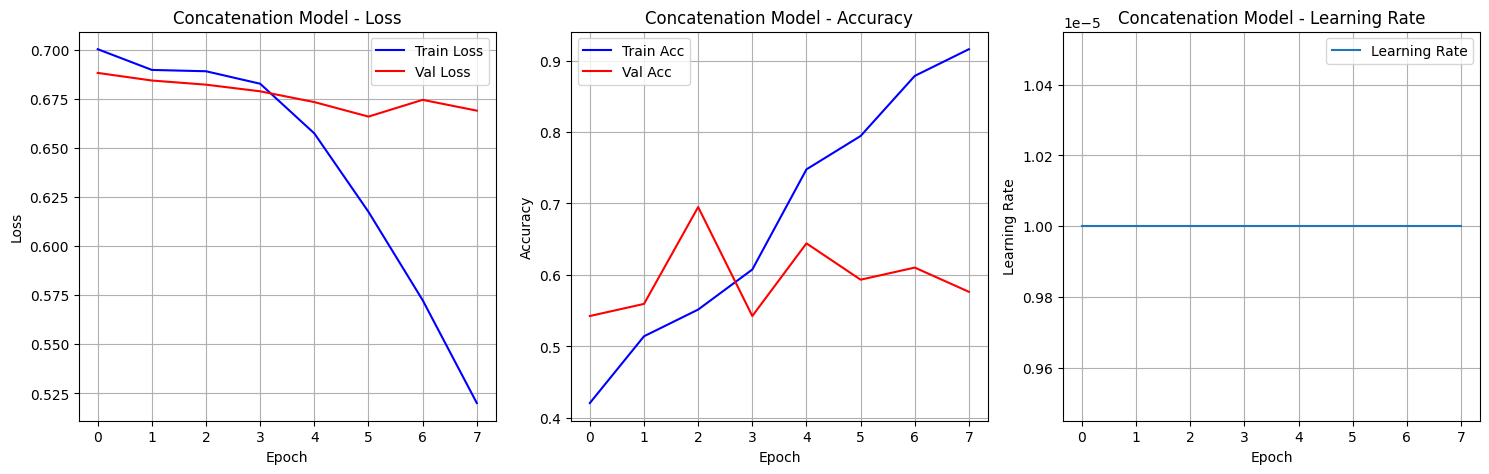


Detailed Evaluation: Concatenation Model
Overall Metrics:
  Accuracy: 0.5932
  Precision (weighted): 0.5951
  Recall (weighted): 0.5932
  F1-Score (weighted): 0.5935

Per-Class Metrics:
  AD:
    Precision: 0.6207
    Recall: 0.5806
    F1-Score: 0.6000
  CN:
    Precision: 0.5667
    Recall: 0.6071
    F1-Score: 0.5862


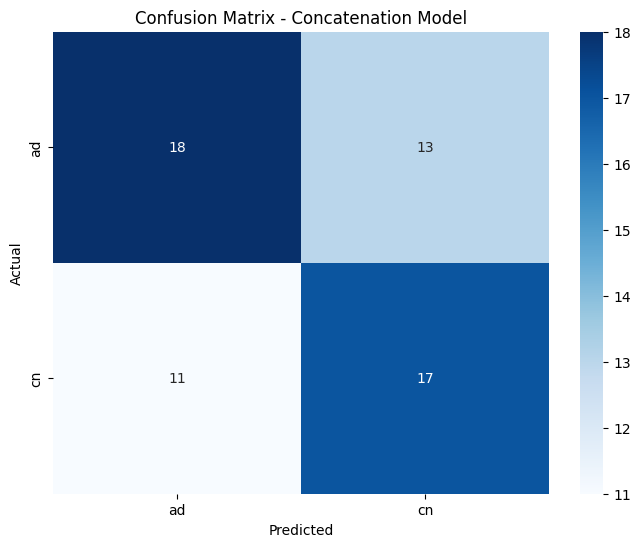


Classification Report:
              precision    recall  f1-score   support

          ad       0.62      0.58      0.60        31
          cn       0.57      0.61      0.59        28

    accuracy                           0.59        59
   macro avg       0.59      0.59      0.59        59
weighted avg       0.60      0.59      0.59        59


🚀 Starting training for GMU Model...

Training GMU Model

Epoch 1/8
------------------------------
Epoch 1, Batch 0/14, Loss: 0.6820, Acc: 75.00%
Epoch 1, Batch 10/14, Loss: 0.6492, Acc: 53.41%
Epoch 1 Summary:
  Train Loss: 0.6928, Train Acc: 0.5234
  Val Loss: 0.6810, Val Acc: 0.5424
  Val Precision: 0.7554, Val Recall: 0.5424, Val F1: 0.3988
  Epoch Time: 31.53s
  ✅ New best validation loss: 0.6810

Epoch 2/8
------------------------------
Epoch 2, Batch 0/14, Loss: 0.7170, Acc: 37.50%
Epoch 2, Batch 10/14, Loss: 0.7270, Acc: 59.09%
Epoch 2 Summary:
  Train Loss: 0.6775, Train Acc: 0.5888
  Val Loss: 0.6714, Val Acc: 0.5763
  Val Precisi

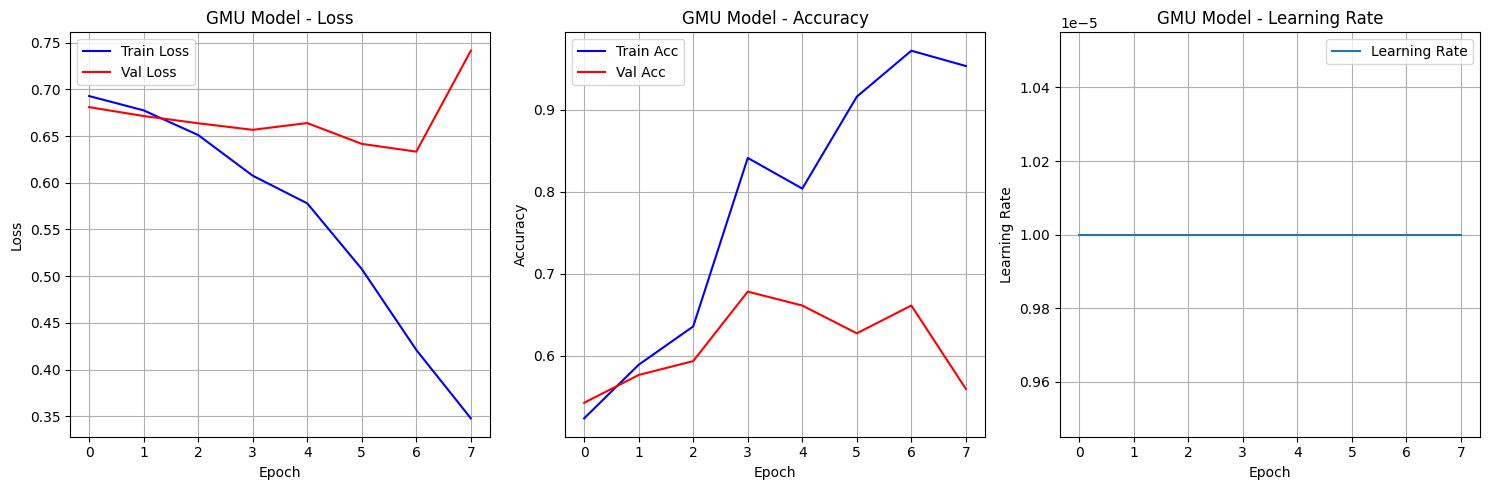


Detailed Evaluation: GMU Model
Overall Metrics:
  Accuracy: 0.6610
  Precision (weighted): 0.6610
  Recall (weighted): 0.6610
  F1-Score (weighted): 0.6610

Per-Class Metrics:
  AD:
    Precision: 0.6774
    Recall: 0.6774
    F1-Score: 0.6774
  CN:
    Precision: 0.6429
    Recall: 0.6429
    F1-Score: 0.6429


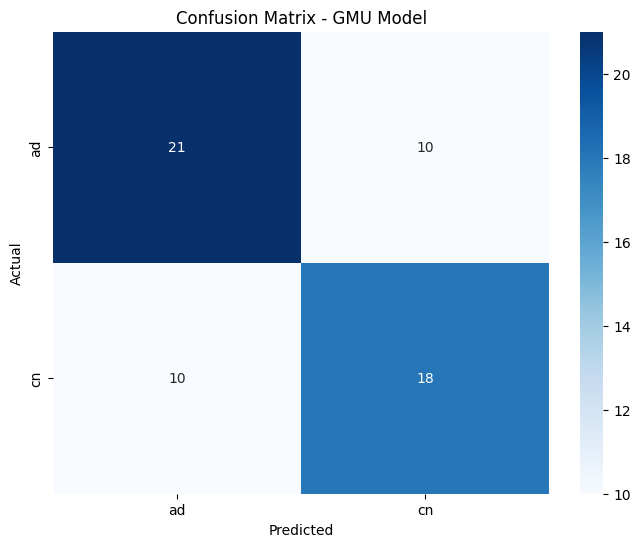


Classification Report:
              precision    recall  f1-score   support

          ad       0.68      0.68      0.68        31
          cn       0.64      0.64      0.64        28

    accuracy                           0.66        59
   macro avg       0.66      0.66      0.66        59
weighted avg       0.66      0.66      0.66        59


🚀 Starting training for Cross-Attention Model...

Training Cross-Attention Model

Epoch 1/8
------------------------------
Epoch 1, Batch 0/14, Loss: 0.7116, Acc: 37.50%
Epoch 1, Batch 10/14, Loss: 0.7036, Acc: 44.32%
Epoch 1 Summary:
  Train Loss: 0.6964, Train Acc: 0.4766
  Val Loss: 0.6977, Val Acc: 0.4746
  Val Precision: 0.2252, Val Recall: 0.4746, Val F1: 0.3055
  Epoch Time: 31.63s
  ✅ New best validation loss: 0.6977

Epoch 2/8
------------------------------
Epoch 2, Batch 0/14, Loss: 0.6909, Acc: 37.50%
Epoch 2, Batch 10/14, Loss: 0.6930, Acc: 47.73%
Epoch 2 Summary:
  Train Loss: 0.6950, Train Acc: 0.5047
  Val Loss: 0.6924, Val A

In [ ]:
# Step 6: Run Training and Evaluation

# Set training parameters
EPOCHS = 8  # Reduced for faster training, increase for better results
LEARNING_RATE = 1e-5  # Lower learning rate for fine-tuning
PATIENCE = 3  # Early stopping patience

print(f"Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Device: {device}")
print(f"  Early Stopping Patience: {PATIENCE}")

# Dictionary to store results
results = {}

# Train Model 1: Concatenation
print(f"\n🚀 Starting training for Concatenation Model...")
try:
    history_concat = train_model(
        model=model_concat,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        model_name="Concatenation Model",
        patience=PATIENCE
    )
    results['concatenation'] = history_concat

    # Detailed evaluation on validation set
    eval_results_concat = detailed_evaluation(
        model=model_concat,
        data_loader=val_loader,
        dataset=val_dataset,
        device=device,
        model_name="Concatenation Model"
    )
    results['concatenation']['eval'] = eval_results_concat

except Exception as e:
    print(f"❌ Error training Concatenation Model: {e}")
    print("This might be due to GPU memory issues. Try reducing batch size.")

# Clear GPU memory before next model
torch.cuda.empty_cache()

# Train Model 2: Gated Multimodal Unit
print(f"\n🚀 Starting training for GMU Model...")
try:
    history_gmu = train_model(
        model=model_gmu,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        model_name="GMU Model",
        patience=PATIENCE
    )
    results['gmu'] = history_gmu

    # Detailed evaluation on validation set
    eval_results_gmu = detailed_evaluation(
        model=model_gmu,
        data_loader=val_loader,
        dataset=val_dataset,
        device=device,
        model_name="GMU Model"
    )
    results['gmu']['eval'] = eval_results_gmu

except Exception as e:
    print(f"❌ Error training GMU Model: {e}")
    print("This might be due to GPU memory issues. Try reducing batch size.")

# Clear GPU memory before next model
torch.cuda.empty_cache()

# Train Model 3: Cross-Modal Attention
print(f"\n🚀 Starting training for Cross-Attention Model...")
try:
    history_cross = train_model(
        model=model_cross_attn,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        model_name="Cross-Attention Model",
        patience=PATIENCE
    )
    results['cross_attention'] = history_cross

    # Detailed evaluation on validation set
    eval_results_cross = detailed_evaluation(
        model=model_cross_attn,
        data_loader=val_loader,
        dataset=val_dataset,
        device=device,
        model_name="Cross-Attention Model"
    )
    results['cross_attention']['eval'] = eval_results_cross

except Exception as e:
    print(f"❌ Error training Cross-Attention Model: {e}")
    print("This might be due to GPU memory issues. Try reducing batch size.")

# Compare Models
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_data = []
for model_name, result in results.items():
    if 'eval' in result:
        comparison_data.append({
            'Model': model_name.replace('_', ' ').title(),
            'Accuracy': f"{result['eval']['accuracy']:.4f}",
            'Precision': f"{result['eval']['precision']:.4f}",
            'Recall': f"{result['eval']['recall']:.4f}",
            'F1-Score': f"{result['eval']['f1']:.4f}",
            'Best Val Loss': f"{result['best_val_loss']:.4f}"
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # Find best model
    best_model_idx = comparison_df['F1-Score'].astype(float).idxmax()
    best_model_name = comparison_df.iloc[best_model_idx]['Model']

    print(f"\n🏆 Best performing model: {best_model_name}")
    print(f"   F1-Score: {comparison_df.iloc[best_model_idx]['F1-Score']}")
    print(f"   Accuracy: {comparison_df.iloc[best_model_idx]['Accuracy']}")
else:
    print("No models completed training successfully.")

# Plot comparison of training curves
if len(results) > 1:
    plt.figure(figsize=(15, 10))

    # Validation Loss Comparison
    plt.subplot(2, 2, 1)
    for model_name, result in results.items():
        if 'val_losses' in result:
            plt.plot(result['val_losses'], label=model_name.replace('_', ' ').title())
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Validation Accuracy Comparison
    plt.subplot(2, 2, 2)
    for model_name, result in results.items():
        if 'val_accuracies' in result:
            plt.plot(result['val_accuracies'], label=model_name.replace('_', ' ').title())
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Training Loss Comparison
    plt.subplot(2, 2, 3)
    for model_name, result in results.items():
        if 'train_losses' in result:
            plt.plot(result['train_losses'], label=model_name.replace('_', ' ').title())
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Training Accuracy Comparison
    plt.subplot(2, 2, 4)
    for model_name, result in results.items():
        if 'train_accuracies' in result:
            plt.plot(result['train_accuracies'], label=model_name.replace('_', ' ').title())
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Save models (optional)
save_models = False  # Set to True if you want to save the trained models

if save_models:
    print(f"\n💾 Saving trained models...")

    # Create models directory
    models_dir = "/content/trained_models"
    os.makedirs(models_dir, exist_ok=True)

    # Save each trained model
    for model_name, model in [("concatenation", model_concat),
                             ("gmu", model_gmu),
                             ("cross_attention", model_cross_attn)]:
        if model_name in results:
            model_path = os.path.join(models_dir, f"{model_name}_model.pth")
            torch.save(model.state_dict(), model_path)
            print(f"  Saved {model_name} model to {model_path}")

    print("✅ Models saved successfully!")

print(f"\n🎉 Training and evaluation completed!")
print(f"Total trained models: {len(results)}")

# Clean up GPU memory
torch.cuda.empty_cache()